# Wrangling Video Data

This tutorial will guide you through using Pixeltable for basic video data wrangling. You'll learn how to:

- Create and populate tables with video data.
- Use Pixeltable's component view mechanism to work with video frames.
- Perform object detection with built-in models.

## Prerequisites

- Basic understanding of Python and dataframes.
- Pixeltable installed.
- YOLOX library installed.

### Setting Up

First, let's create a directory to organize our tables and install the necessary libraries:

In [1]:
# Install the YOLOX object detection library
%pip install -q pixeltable git+https://github.com/Megvii-BaseDetection/YOLOX@ac58e0a

import pixeltable as pxt

# Create a directory
pxt.create_dir('video_tutorial', ignore_errors=True)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 47.9 MB/s eta

### Creating a Table for Videos

In [2]:
# Drop the tables if they exist
pxt.drop_table('video_tutorial.frames', ignore_errors=True)
pxt.drop_table('video_tutorial.videos', ignore_errors=True)

# Create the table for video files
videos_table = pxt.create_table('video_tutorial.videos', {'video': pxt.VideoType()})

Created table `videos`.


- Pixeltable tables store data in a structured format.
- The VideoType() column type enables efficient handling of video data.

### Working with Video Frames

Pixeltable's component view mechanism provides a "view" of your video table, with each row representing a single frame from each video in the table.

In [3]:
from pixeltable.iterators import FrameIterator

frames_view = pxt.create_view(
    'video_tutorial.frames',
    videos_table,
    iterator=FrameIterator.create(video=videos_table.video, fps=0)  # Use original frame rate
)

Created view `frames` with 0 rows, 0 exceptions.


FrameIterator: This built-in class allows you to iterate over video frames and access frame-specific information like frame_idx, pos_msec, etc.

### Adding a Video

In [4]:
videos_table.insert([{'video': 'https://raw.github.com/pixeltable/pixeltable/master/docs/source/data/bangkok.mp4'}])

Inserting rows into `videos`: 1 rows [00:00, 129.06 rows/s]
Inserting rows into `frames`: 462 rows [00:00, 6688.53 rows/s]
Inserted 463 rows with 0 errors.


UpdateStatus(num_rows=463, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

This inserts a video from a remote location (URL) into your video_table. Pixeltable will automatically extract frames into the frames_view!

### Object Detection with YOLOX

Pixeltable provides easy access to popular computer vision models like YOLOX.

In [5]:
from pixeltable.ext.functions.yolox import yolox

# Add a computed column for object detection results
frames_view['detect_yolox_tiny'] = yolox(frames_view.frame, model_id='yolox_tiny', threshold=0.25)

Computing cells: 100%|████████████████████████████████████████| 462/462 [01:44<00:00,  4.41 cells/s]
Added 462 column values with 0 errors.


- yolox function: This function applies the YOLOX object detection model to each frame.
- threshold parameter: Adjusts the sensitivity of the model (lower values detect more objects).

### Visualizing Detections

Let's visualize the object detection results.

frame,col_1
,

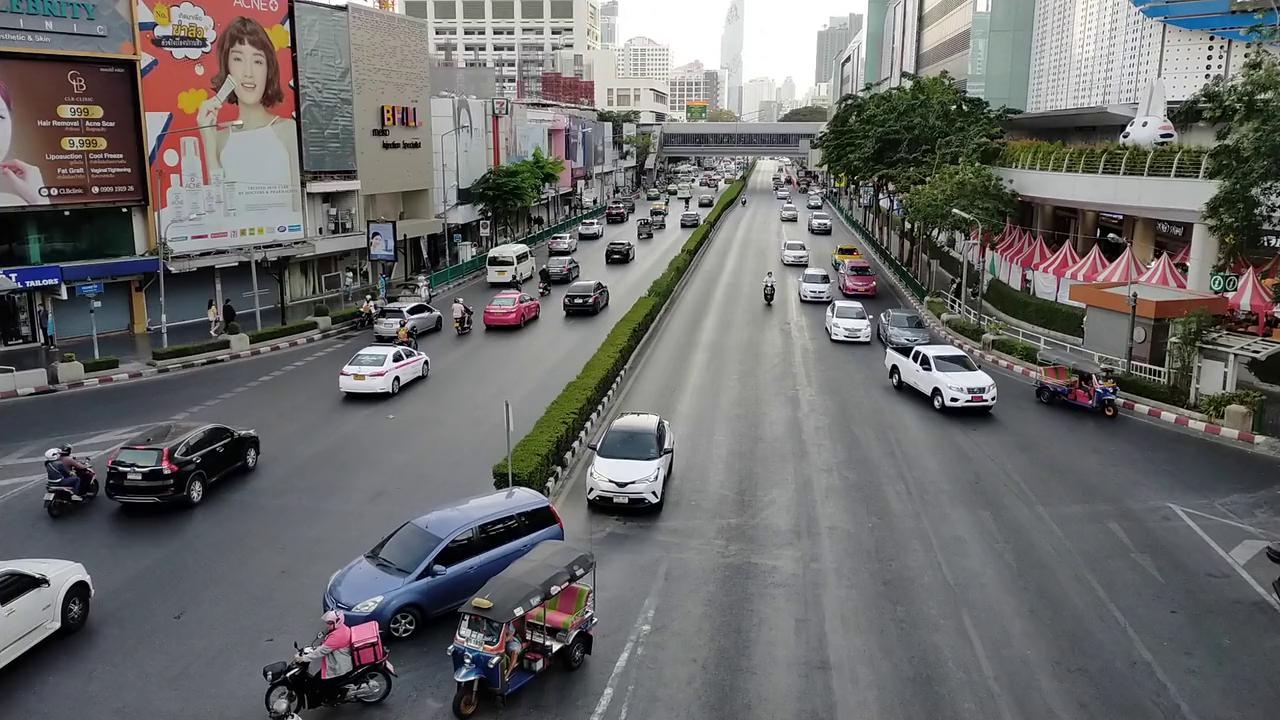
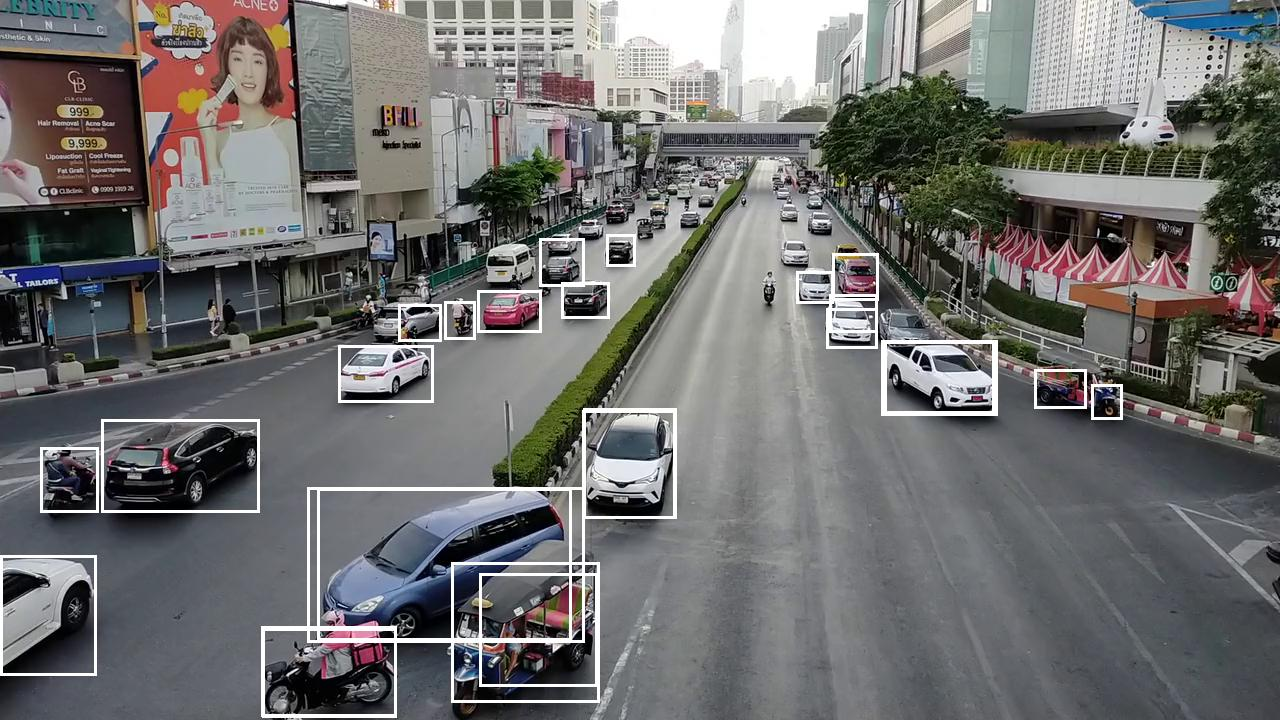

In [8]:
import PIL.Image
import PIL.ImageDraw

@pxt.udf
def draw_boxes(img: PIL.Image.Image, boxes: list[list[float]]) -> PIL.Image.Image:
    result = img.copy()
    d = PIL.ImageDraw.Draw(result)
    for box in boxes:
        d.rectangle(box, width=3)
    return result

frames_view.select(frames_view.frame, draw_boxes(frames_view.frame, frames_view.detect_yolox_tiny.bboxes)).show(1)  # Visualize one frame with boxes

We define a custom function draw_boxes [UDF](https://pixeltable.readme.io/docs/user-defined-functions-udfs) to overlay the detected bounding boxes onto the image frames.

###  Generating Annotated Video

col_0
""

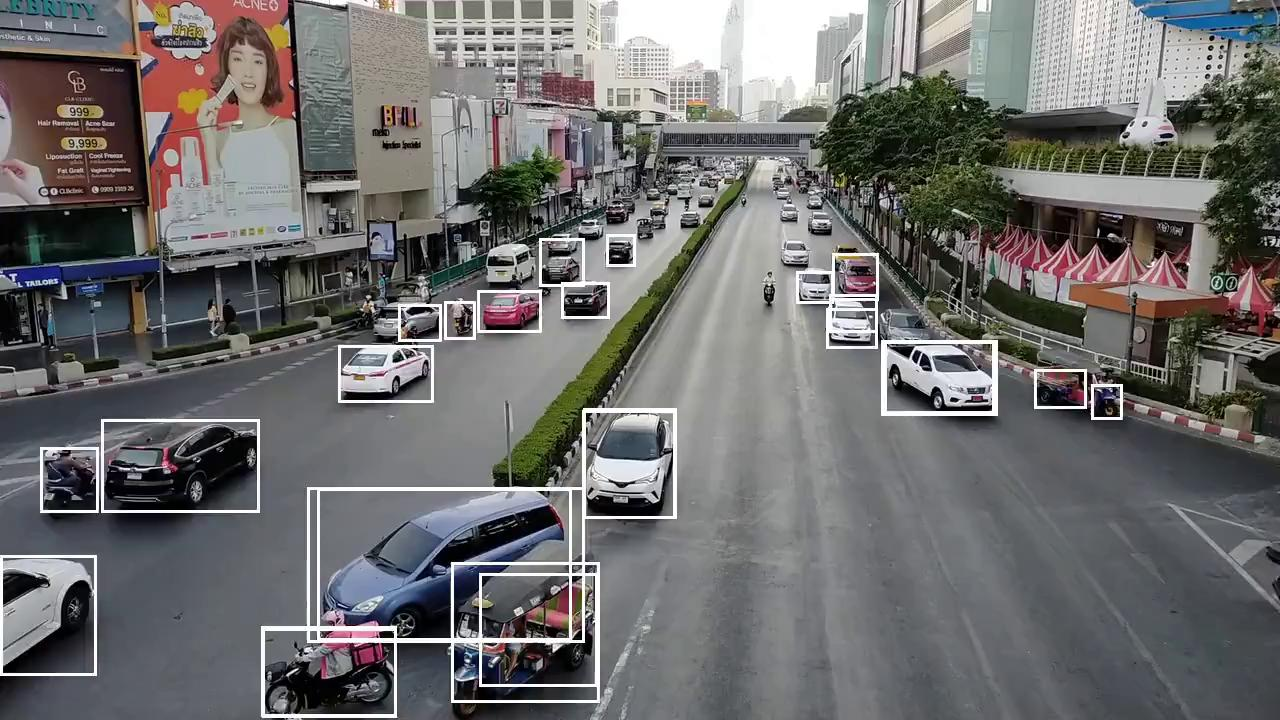

In [9]:
frames_view.select(pxt.functions.make_video(
    frames_view.pos, draw_boxes(frames_view.frame, frames_view.detect_yolox_tiny.bboxes)
)).group_by(videos_table).show(1)

The `make_video` function assembles the annotated frames back into a video, which you can view directly in your notebook.

## Next Steps

Learn more about using other computer vision models in Pixeltable. Explore how to evaluate models against ground truth annotations:https://pixeltable.readme.io/docs/object-detection-in-videos.

## Key Takeaways

- Pixeltable's frame iterator allows you to easily work with video data, avoiding manual frame extraction and storage overhead.
- You can apply state-of-the-art models to your video data using built-in functions and customize the results with user-defined functions (UDFs).
- Visualize and evaluate your results directly within Pixeltable, aiding in model development and refinement.